In [284]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 

def segmentation(img):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to Grayscale ---
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    luminance = hsv[:, :, 2]

    # --- 3. Blur to Reduce Noise ---
    blurred = cv2.GaussianBlur(luminance, (5, 5), 0)

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(blurred, 50, 150)

    # --- 5. Dilate to Connect Broken Edges ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # --- 6. Morphological Closing to Fill Gaps ---
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

    # --- 7. Remove Small Objects by Area Filtering ---
    # Find all contours
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)


    #plot contours
    #cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
    #cv2.imshow("Contours", img)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(closed)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Skip tiny noise
        if area < 2000:
            if len(cnt) >= 5:
                ellipse = cv2.fitEllipse(cnt)
                (x, y), (MA, ma), angle = ellipse
                if MA > 5 and ma > 5:
                    cv2.ellipse(mask, ellipse, 255, -1)
        else:
            # If not enough points, fall back to filled contour
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)


    return segmented_objects

def plot_choc(img):
    plt.figure()
    plt.imshow(img)
    plt.title("Chocolate")
    plt.axis('off')
    plt.show()

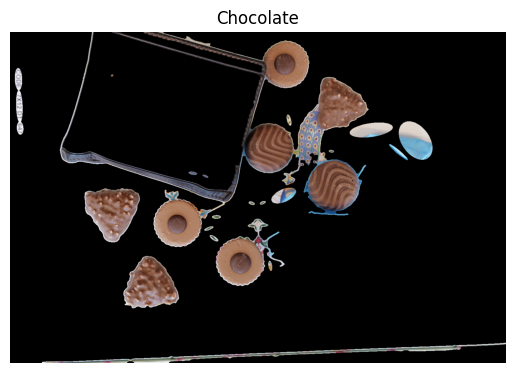

In [285]:
path_ref = 'dataset_project_iapr2025/train/L1010035.JPG'
im_org = os.path.join(path_ref)
img = mpimg.imread(im_org)
res = segmentation(img)
plot_choc(res)